In [ ]:
!pip install pandas bertopic datamapplot==0.3.0 langdetect kaleido numpy==1.26.4 pandas==2.2.2 "scipy>=1.7.0,<1.14.0" "toolz>=0.11,<1.0" dask==2024.8.0 optuna scikit-optimize

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from bertopic.representation import KeyBERTInspired

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/AI Landscape Large Files/Data/constructed/wp_topic_modeling/')

**Load the data**

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/AI Landscape Large Files/Data/constructed/wp_classification/classed_wps_3.csv', index_col = 0)

# data = data.reset_index()
# data = data[data['GPT_class'] == 'A']
# data = data[['abstract', 'doi']]
# data

**Set up the topic model**

In [ ]:
# # Define docs

# documents = data['abstract']
# documents = documents.reset_index(drop=True)
# documents = documents.tolist()
# documents = [str(doc) for doc in documents if isinstance(doc, str)]

In [ ]:
# # Get embeddings

# from sentence_transformers import SentenceTransformer
# import numpy as np

# embedding_model = SentenceTransformer("all-roberta-large-v1")
# embeddings = embedding_model.encode(documents, show_progress_bar=True)
# embeddings = embeddings.astype(np.float64)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics.pairwise import pairwise_distances

# # Define your parameter range for min_cluster_size
# min_cluster_sizes = range(10, 100, 10)
# max_distances = []
# num_topics = []

# for min_cluster_size in min_cluster_sizes:
#     # Update the HDBSCAN model with the new min_cluster_size
#     hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean',
#                             cluster_selection_method='eom', prediction_data=True)

#     # Initialise the BERTopic model
#     topic_model = BERTopic(
#         embedding_model=None,
#         umap_model=UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42),
#         hdbscan_model=hdbscan_model,
#         vectorizer_model=CountVectorizer(stop_words="english")
#     )

#     # Fit the model on your data
#     topics, probs = topic_model.fit_transform(documents, embeddings)

#     # Calculate maximum distance for each cluster
#     cluster_distances = []
#     for cluster in set(topics):
#         if cluster == -1:  # Skip the outliers
#             continue
#         cluster_points = embeddings[np.array(topics) == cluster]
#         if len(cluster_points) > 1:  # Avoid single-point clusters
#             max_distance = pairwise_distances(cluster_points).max()
#             cluster_distances.append(max_distance)

#     # Record metrics
#     max_distances.append(np.mean(cluster_distances))  # Average max intra-cluster distance
#     num_topics.append(len(set(topics)) - (1 if -1 in topics else 0))  # Number of topics

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(num_topics, max_distances, marker='o')
# plt.xlabel("Number of Topics")
# plt.ylabel("Average Max Distance in Clusters")
# plt.title("Cluster Compactness vs Number of Topics")
# plt.show()


In [ ]:
# ## Min cluster size = 30 seems like the best choice here.

# # Update the HDBSCAN model with the new min_cluster_size
# hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean',
#                         cluster_selection_method='eom', prediction_data=True)

# # Initialise the BERTopic model
# topic_model = BERTopic(
#     embedding_model=None,
#     umap_model=UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42),
#     hdbscan_model=hdbscan_model,
#     vectorizer_model=CountVectorizer(stop_words="english")
# )

# # Fit the model on your data
# topics, probs = topic_model.fit_transform(documents, embeddings)

# # Calculate maximum distance for each cluster
# cluster_distances = []
# for cluster in set(topics):
#     if cluster == -1:  # Skip the outliers
#         continue
#     cluster_points = embeddings[np.array(topics) == cluster]
#     if len(cluster_points) > 1:  # Avoid single-point clusters
#         max_distance = pairwise_distances(cluster_points).max()
#         cluster_distances.append(max_distance)

# # Record metrics
# print(np.mean(cluster_distances))  # Average max intra-cluster distance
# print(len(set(topics)) - (1 if -1 in topics else 0))  # Number of topics

In [ ]:
# topic_df = topic_model.get_topic_info()
# topic_df.to_csv('topics_wps_prelim.csv')
# topic_df

In [ ]:
# topic_df = pd.read_csv('topics_wps_prelim.csv', index_col = 0)
# topic_df

In [ ]:
# papers_topics = pd.DataFrame({'abstract': documents, 'Topic': topics, 'Probability': probs})
# papers_topics = papers_topics.merge(data, on = "abstract", how = "inner")
# papers_topics.to_csv('papers_topics_wp_prelim.csv')
# papers_topics

In [ ]:
# for topic in range(-1, len(topic_df)):
#   try:
#     sample = papers_topics[papers_topics['Topic'] == topic].sample(n=50, random_state=123)
#   except ValueError:
#     sample = papers_topics[papers_topics['Topic'] == topic]
#   sample.to_csv(f'by_topic/classed_{topic}s.csv')

**Remove low accuracy topics and non-english abstracts**

In [ ]:
# is english?

def is_english(text):
    try:
        # Skip empty abstracts
        if pd.isna(text) or text.strip() == '':
            return False
        # Detect language
        return detect(text) == 'en'
    except LangDetectException:
        # If there's an error in detection, assume it's not English
        return False

In [ ]:
from langdetect import detect, LangDetectException

papers_topics_old = pd.read_csv('papers_topics_wp_prelim.csv', index_col = 0)
papers_topics_old = papers_topics_old[papers_topics_old['Topic'] != 3] # remove low accuracy
print(len(papers_topics_old))
papers_topics_old = papers_topics_old[papers_topics_old['abstract'].apply(is_english)] # remove non-english
print(len(papers_topics_old))
papers_topics_old = papers_topics_old.drop_duplicates(subset = ['abstract']) # remove duplicates
papers_topics_old.to_csv('papers_topics_nocits.csv')
print(len(papers_topics_old))
papers_topics_old = papers_topics_old[['abstract', 'doi']]
papers_topics_old

1217
1205
1111


,abstract,doi
0,Do stronger intellectual property rights incen...,10.3386/w32547
1,Drawing insights from the field of innovation ...,10.3386/w32474
2,How will the emergence of ChatGPT and other fo...,10.3386/w32430
3,David Ricardo initially believed machinery wou...,10.3386/w32416
4,Timely and accurate measurement of AI use by f...,10.3386/w32319
...,...,...
1294,Can artificial intelligence (AI) assist human ...,10.2139/ssrn.4397280
1295,This paper looks at transparency and fintech t...,NaN
1296,The knowledge-based and data-driven economy re...,10.2139/ssrn.3110785
1297,Credit risk is probably the most regulated app...,10.2139/ssrn.4615412


In [ ]:
# merge with citations

citations = pd.read_csv('citations.csv', index_col = 0)
citations = citations.drop_duplicates(subset = ['doi'])
papers_topics_cits = papers_topics_old.merge(citations, on = 'doi', how = 'left')

citations_nodois = pd.read_csv('citations_abstracts.csv', index_col = 0)
citations_nodois = citations_nodois.rename(columns = {'abstract': 'abstract_short'})
citations_nodois = citations_nodois.drop_duplicates(subset = ['abstract_short'])

papers_topics_cits['abstract_short'] = papers_topics_cits['abstract'].str[:500]
papers_topics_cits = papers_topics_cits.merge(citations_nodois, on = 'abstract_short', how = 'left')

papers_topics_cits['citation_count'] = papers_topics_cits['citation_count_x'].fillna(papers_topics_cits['citation_count_y'])
papers_topics_cits = papers_topics_cits.drop(columns = ['citation_count_x', 'citation_count_y', 'abstract_short'])

print(len(papers_topics_cits))
papers_topics_cits = papers_topics_cits.dropna(subset = 'citation_count') # drop papers without citations
print(len(papers_topics_cits))
papers_topics_cits = papers_topics_cits[['abstract', 'doi', 'citation_count']]
papers_topics_cits

1111
1031


,abstract,doi,citation_count
0,Do stronger intellectual property rights incen...,10.3386/w32547,0.0
1,Drawing insights from the field of innovation ...,10.3386/w32474,32.0
2,How will the emergence of ChatGPT and other fo...,10.3386/w32430,19.0
3,David Ricardo initially believed machinery wou...,10.3386/w32416,8.0
4,Timely and accurate measurement of AI use by f...,10.3386/w32319,23.0
...,...,...,...
1106,Can artificial intelligence (AI) assist human ...,10.2139/ssrn.4397280,237.0
1107,This paper looks at transparency and fintech t...,NaN,1.0
1108,The knowledge-based and data-driven economy re...,10.2139/ssrn.3110785,42.0
1109,Credit risk is probably the most regulated app...,10.2139/ssrn.4615412,1.0


In [ ]:
# Redefine docs

data_new = papers_topics_cits
documents = data_new['abstract']
documents = documents.reset_index(drop=True)
documents = documents.tolist()
documents = [str(doc) for doc in documents if isinstance(doc, str)]

In [ ]:
# Get embeddings

from sentence_transformers import SentenceTransformer
import numpy as np

embedding_model = SentenceTransformer("all-roberta-large-v1")
embeddings = embedding_model.encode(documents, show_progress_bar=True)
embeddings = embeddings.astype(np.float64)

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
# Function to get coherence score

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora

def calculate_coherence_score(topic_model, docs):
    # Preprocess documents
    cleaned_docs = topic_model._preprocess_text(docs)

    # Extract vectorizer and tokenizer from BERTopic
    vectorizer = topic_model.vectorizer_model
    tokenizer = vectorizer.build_tokenizer()

    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    # depending on the version and if you get an error use commented out code below:
    # words = vectorizer.get_feature_names()
    tokens = [tokenizer(doc) for doc in cleaned_docs]
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    # Create topic words
    # topic_words = [[dictionary.token2id[w] for w in words if w in dictionary.token2id] for _ in range(topic_model.nr_topics)]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

    # this creates a list of the token ids (in the format of integers) of the words in words that are also present in the
    # dictionary created from the preprocessed text. The topic_words list contains list of token ids for each
    # topic.

    coherence_model = CoherenceModel(topics=topic_words,
                                    texts=tokens,
                                    corpus=corpus,
                                    dictionary=dictionary,
                                    coherence='c_v')
    coherence = coherence_model.get_coherence()

    return coherence

Min cluster size: 10, Coherence: 0.37396851519243046, Number of uncategorized: 0
Min cluster size: 15, Coherence: 0.45170021928908227, Number of uncategorized: 372
Min cluster size: 20, Coherence: 0.44618838707725017, Number of uncategorized: 421
Min cluster size: 25, Coherence: 0.4414203411427817, Number of uncategorized: 467
Min cluster size: 30, Coherence: 0.4617271348998471, Number of uncategorized: 551
Min cluster size: 35, Coherence: 0.492041501382854, Number of uncategorized: 623
Min cluster size: 40, Coherence: 0.4473823060335405, Number of uncategorized: 606
Min cluster size: 45, Coherence: 0.41933729229761174, Number of uncategorized: 450
Min cluster size: 50, Coherence: 0.4154611763987836, Number of uncategorized: 492
Min cluster size: 55, Coherence: 0.41546117639878355, Number of uncategorized: 514
Min cluster size: 60, Coherence: 0.43421653840778185, Number of uncategorized: 569
Min cluster size: 65, Coherence: 0.4348900419042413, Number of uncategorized: 490
Min cluster s

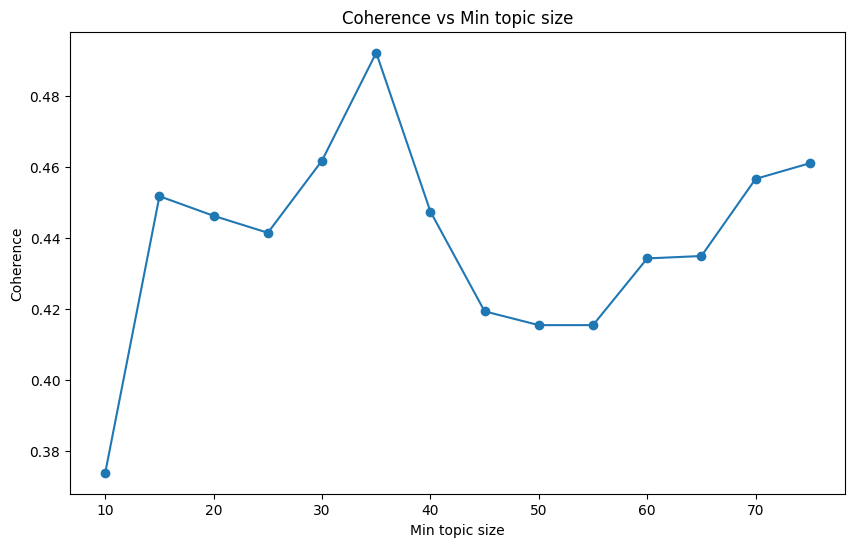

In [ ]:
import numpy
import matplotlib.pyplot as plt

# Define parameter range for min_cluster_size
min_cluster_sizes = range(10, 80, 5)
coherences = []
num_topics = []
min_clusters = []
uncategorized_topics = []

for min_cluster_size in min_cluster_sizes:
    # Update the HDBSCAN model with the new min_cluster_size
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean',
                            cluster_selection_method='eom', prediction_data=True)

    # Initialise the BERTopic model
    topic_model = BERTopic(
        embedding_model=None,
        umap_model=UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42),
        hdbscan_model=hdbscan_model,
        vectorizer_model=CountVectorizer(stop_words="english")
    )
    topics, probs = topic_model.fit_transform(documents, embeddings)

    # Get coherence
    coherence = calculate_coherence_score(topic_model, documents)

    # Get the number of uncategorised topics
    uncategorized = topics.count(-1)

    # Append to list
    coherences.append(coherence)
    num_topics.append(len(set(topics)) - (1 if -1 in topics else 0))  # Number of topics
    min_clusters.append(min_cluster_size)
    uncategorized_topics.append(uncategorized)
    print(f"Min cluster size: {min_cluster_size}, Coherence: {coherence}, Number of uncategorized: {uncategorized}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(min_clusters, coherences, marker='o')
plt.xlabel("Min topic size")
plt.ylabel("Coherence")
plt.title("Coherence vs Min topic size")
plt.show()


In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# function for getting topic model
def create_topic_model(documents, min_cluster_size):
  hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean',
                          cluster_selection_method='eom', prediction_data=True)

  # Initialise the BERTopic model
  topic_model = BERTopic(
      embedding_model=None,
      umap_model=UMAP(n_neighbors=15, n_components=5, metric='cosine', random_state=42),
      hdbscan_model=hdbscan_model,
      vectorizer_model=CountVectorizer(stop_words="english")
  )

  # get embeddings
  embedding_model = SentenceTransformer("all-roberta-large-v1")
  embeddings = embedding_model.encode(documents, show_progress_bar=True)
  embeddings = embeddings.astype(np.float64)

  # Fit the model on your data
  topics, probs = topic_model.fit_transform(documents, embeddings)

  # return topics, probs, topic model
  return topics, probs, topic_model

# run
topics, probs, topic_model = create_topic_model(documents, 15)

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

In [ ]:
topic_df = topic_model.get_topic_info()
topic_df.to_csv('topics_wps.csv')
topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,372,-1_ai_data_digital_technology,"[ai, data, digital, technology, artificial, in...",[Korean Abstract: 본 연구는 4차 산업혁명 시대의 새로운 변화 속에 ...
1,0,190,0_workers_automation_ai_labor,"[workers, automation, ai, labor, growth, emplo...",[The rapid development of artificial intellige...
2,1,138,1_financial_credit_banking_ai,"[financial, credit, banking, ai, data, artific...",[The use of algorithmic credit scoring present...
3,2,73,2_chatgpt_generative_ai_service,"[chatgpt, generative, ai, service, content, st...",[Artificial intelligence (Al) tools have broug...
4,3,62,3_ai_systems_public_governance,"[ai, systems, public, governance, intelligence...",[The field of artificial intelligence (AI) is ...
5,4,56,4_firms_returns_investors_market,"[firms, returns, investors, market, informatio...",[The introduction of ChatGPT and other tools b...
6,5,42,5_intelligence_artificial_ai_hr,"[intelligence, artificial, ai, hr, study, empl...",[Marketing of agricultural products has a spec...
7,6,26,6_patent_ai_law_property,"[patent, ai, law, property, intellectual, inve...",[We are at the dawn of a paradigm shift of the...
8,7,23,7_healthcare_ai_medical_health,"[healthcare, ai, medical, health, intelligence...",[The role of artificial intelligence (AI) in a...
9,8,18,8_decision_decisionmaking_dm_ai,"[decision, decisionmaking, dm, ai, advice, hum...",[Artificial intelligence systems are increasin...


In [ ]:
papers_topics = pd.DataFrame({'abstract': documents, 'Topic': topics, 'Probability': probs})
papers_topics = papers_topics.merge(data_new[['abstract', 'doi']], on = "abstract", how = "inner")
papers_topics = papers_topics.drop_duplicates(subset = ['abstract'])
papers_topics.to_csv('papers_topics_wps.csv')
papers_topics

,abstract,Topic,Probability,doi
0,Do stronger intellectual property rights incen...,-1,0.000000,10.3386/w32547
1,Drawing insights from the field of innovation ...,-1,0.000000,10.3386/w32474
2,How will the emergence of ChatGPT and other fo...,0,1.000000,10.3386/w32430
3,David Ricardo initially believed machinery wou...,0,1.000000,10.3386/w32416
4,Timely and accurate measurement of AI use by f...,-1,0.000000,10.3386/w32319
...,...,...,...,...
1026,Can artificial intelligence (AI) assist human ...,2,0.777859,10.2139/ssrn.4397280
1027,This paper looks at transparency and fintech t...,1,0.882632,NaN
1028,The knowledge-based and data-driven economy re...,10,1.000000,10.2139/ssrn.3110785
1029,Credit risk is probably the most regulated app...,1,0.767300,10.2139/ssrn.4615412


In [ ]:
# merge with citations

papers_topics = papers_topics.merge(papers_topics_cits, on = ['abstract', 'doi'], how = 'left')
print(len(papers_topics))
papers_topics = papers_topics.drop_duplicates(subset = ['abstract'])
print(len(papers_topics))
papers_topics

1031
1031


,abstract,Topic,Probability,doi,citation_count
0,Do stronger intellectual property rights incen...,-1,0.000000,10.3386/w32547,0.0
1,Drawing insights from the field of innovation ...,-1,0.000000,10.3386/w32474,32.0
2,How will the emergence of ChatGPT and other fo...,0,1.000000,10.3386/w32430,19.0
3,David Ricardo initially believed machinery wou...,0,1.000000,10.3386/w32416,8.0
4,Timely and accurate measurement of AI use by f...,-1,0.000000,10.3386/w32319,23.0
...,...,...,...,...,...
1026,Can artificial intelligence (AI) assist human ...,2,0.777859,10.2139/ssrn.4397280,237.0
1027,This paper looks at transparency and fintech t...,1,0.882632,NaN,1.0
1028,The knowledge-based and data-driven economy re...,10,1.000000,10.2139/ssrn.3110785,42.0
1029,Credit risk is probably the most regulated app...,1,0.767300,10.2139/ssrn.4615412,1.0


**Now extract research questions**

In [ ]:
# ## WRITE PROMPT

# prompt = "You are an academic expert in economics, finance, management and innovation studies. You are provided with abstracts from academic papers. Your goal is to carefully review each abstract to identify the main research question. Then, summarize this research question in less than 50 words."

# example1 = """The environmental effect of operating activities in the manufacturing industry is crucial to the sustainable development of the economy and society. Since we have entered the era of information explosion, the artificial intelligence has been involved to address the environmental problems caused by daily operations. This study examines the complex relation between artificial intelligence application and corporate environmental investment. The results show that: (1) AI application have a direct and positive impact on corporate environmental investment; (2) Managerial myopia plays a negative moderating role, inhibiting the positive effect of AI application on corporate environmental investment; (3) Companies' pollution emission mediates the relationship between AI application and corporate environmental investment. When reduced by AI application, a lower pollution emission will trigger a larger scale of corporate environmental investment; (4) Compared with under-valued companies and those in the Western region, AI application has a greater positive impact on the environmental investment of the over-valued companies and those in the East-Central region. By verifying the relationship between artificial intelligence applications and manufacturing enterprise investment, this study has a positive impact on promoting green innovation in the manufacturing industry and is of great significance for sustainable development strategies."""
# output1 = "What is the relationship between artificial intelligence application and corporate environmental investment?"

# example2 = "This paper explores the intersection between artificial intelligence and nuclear energy, shedding light on the intriguing scenario when these two sectors jointly consturct. Through the application of both full-sample and sub-sample methodologies, this study identifies the time-dependent interrelationships between China's artificial intelligence index (AI) and nuclear energy indicator (NUC). The quantitative analysis presents that AI's influence on nuclear energy is twofold. On one hand, AI contributes positively by acting as a catalyst and enhancing safety measures in the nuclear sector. On the other, the impact might be perceived negatively, primarily when cost-effective alternative energy sources overshadow the benefits of nuclear energy. Additionally, the positive effect of NUC on AI highlights the benefits derived from nuclear's expansive and consistent energy output, catering efficiently to AI's substantial energy demands. In essence, AI and NUC are found to be complementary, with each having the potential to propel the other forward. This reciprocity paves the way for a synergistic relationship, promising mutual benefits. The study introduces a fresh perspective on the co-evolution of energy and technology, offering thought-provoking recommendations aimed at cultivating the collaborative growth of AI and NUC towards a common good. Â© 2023"
# output2 = "What is the relationship between artificial intelligence and nuclear energy, and how do they influence each other's development?"

# example3 = "Fairness is a crucial concept in the context of artificial intelligence ethics and policy. It is an incremental component in existing ethical principle frameworks, especially for algorithm-enabled decision systems. Yet, translating fairness principles into context specific practices can be undermined by multiple unintended organisational risks. This paper argues that there is a gap between the potential and actual realized value of AI. Therefore, this research attempts to answer how organisations can mitigate AI risks that relate to unfair decision outcomes. We take a holistic view by analyzing the challenges throughout a typical AI product life cycle while focusing on the critical question of how rather broadly defined fairness principles may be translated into day-to-day practical solutions at the organizational level. We report on an exploratory case study of a social impact microfinance organization that is using AI-enabled credit scoring to support the screening process to particularly financially marginalized entrepreneurs. This paper highlights the importance of considering the strategic role of the organisation when developing and evaluating fair algorithm- enabled decision systems. The proposed framework and results of this study can be used to inspire the right questions that suit the context an organisation is situated in when implementing fair AI. Â© 2023, The Author(s), under exclusive license to Springer Nature Switzerland AG."
# output3 = "How can organizations translate broad fairness principles into practical solutions to mitigate AI-related risks in decision-making systems?"

# example4 = "The behavior of artificial intelligence (AI) algorithms is shaped by how they learn about their environment. We compare the prices generated by AIs that use different learning protocols when there is market interaction. Asynchronous learning occurs when the AI only learns about the return from the action it took. Synchronous learning occurs when the AI conducts counterfactuals to learn about the returns it would have earned had it taken an alternative action. The two lead to markedly different market prices. When future profits are not given positive weight by the AI, (perfect) synchronous updating leads to competitive pricing, while asynchronous can lead to pricing close to monopoly levels. We investigate how this result varies when either counterfactuals can only be calculated imperfectly and/or when the AI places a weight on future profits. Lastly, we investigate performance differences between offline and online play. Â© 2023 Wiley Periodicals LLC."
# output4 = "How do different AI learning protocols affect market pricing behavior, and what factors influence their competitive or monopolistic outcomes?"

In [ ]:
# ## PROMPT GPT-4o mini

# from openai import OpenAI
# import time
# import logging
# from tqdm import tqdm
# import re
# from google.colab import userdata

# # set up logging
# logging.basicConfig(level = logging.INFO)

# # set up api
# api_key = userdata.get("OPENAI_API_KEY")
# client = OpenAI(api_key = api_key)

# # set up data dict
# data_dict = {
#         'abstract': [],
#         'Question': []
#     }

# # loop through abstracts
# for index, row in tqdm(papers_topics.iterrows(), desc = 'Processing abstracts'):
#     response = client.chat.completions.create(
#         model="gpt-4o-mini",
#         max_tokens=200,
#         temperature=0,
#         seed=2345,
#         messages=[
#             {"role": "system", "content": prompt},
#             {"role": "user", "content": example1},
#             {"role": "assistant", "content": output1},
#             {"role": "user", "content": example2},
#             {"role": "assistant", "content": output2},
#             {"role": "user", "content": example3},
#             {"role": "assistant", "content": output3},
#             {"role": "user", "content": example4},
#             {"role": "assistant", "content": output4},
#             {"role": "user", "content": row['abstract']}
#         ]
#     )

#     # store data in df
#     data_dict['abstract'].append(row['abstract'])
#     message = response.choices[0].message.content
#     data_dict['Question'].append(message)

# # Display the DataFrame
# questions = pd.DataFrame(data_dict)
# questions.to_csv('questions_wps.csv')
# questions

In [ ]:
questions = pd.read_csv('questions_wps.csv', index_col = 0)
papers_topics = papers_topics.merge(questions, on = "abstract", how = "left")

**Now model subtopics**

In [ ]:
import gc

for topic in range(0, len(topic_df)):
  papers = papers_topics[papers_topics['Topic'] == topic][['abstract', 'Cited by', 'doi', 'Question']]
  subdocuments = papers['abstract']
  subdocuments = subdocuments.reset_index(drop=True)
  subdocuments = subdocuments.tolist()
  if len(subdocuments) > 30:
    gc.collect()
    subtopics, subprobs, subtopic_model = create_topic_model(subdocuments, 10)
    citation_count = papers['citation_count']
    mini_df = pd.DataFrame({'abstract': subdocuments, 'Topic': subtopics, 'Probability': subprobs})
    mini_df = mini_df.merge(papers, on = 'abstract', how = 'left')
    mini_df.to_csv(f'subtopics/subtopics_{topic}_papers.csv')
    mini_topic_df = subtopic_model.get_topic_info()
    print(mini_topic_df)
    mini_topic_df.to_csv(f'subtopics/subtopics_{topic}.csv')

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

   Topic  Count                               Name  \
0     -1     59  -1_automation_ai_labor_employment   
1      0     37       0_ai_growth_economic_capital   
2      1     32       1_ai_workers_occupations_job   
3      2     23         2_ai_tasks_volunteers_jobs   
4      3     22  3_tax_robots_social_technological   
5      4     17      4_work_workers_regulation_law   

                                      Representation  \
0  [automation, ai, labor, employment, workers, e...   
1  [ai, growth, economic, capital, model, labor, ...   
2  [ai, workers, occupations, job, technologies, ...   
3  [ai, tasks, volunteers, jobs, productivity, ar...   
4  [tax, robots, social, technological, jobs, new...   
5  [work, workers, regulation, law, workplace, le...   

                                 Representative_Docs  
0  [There is a long-standing economic research li...  
1  [Industrialized countries have long seen relat...  
2  [We study the shifts in U.S. firms' workforce ...  
3  [The 

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

   Topic  Count                                      Name  \
0     -1     50               -1_financial_ai_credit_data   
1      0     41  0_credit_data_discrimination_algorithmic   
2      1     33    1_ai_financial_artificial_intelligence   
3      2     14                  2_banking_banks_ai_study   

                                      Representation  \
0  [financial, ai, credit, data, market, risk, in...   
1  [credit, data, discrimination, algorithmic, us...   
2  [ai, financial, artificial, intelligence, fina...   
3  [banking, banks, ai, study, intelligence, arti...   

                                 Representative_Docs  
0  [This paper explores the dual impact of digita...  
1  [The contemporary financial landscape is witne...  
2  [The EU Artificial Intelligence Act (AI Act) i...  
3  [Digitalization is the process of moving to a ...  


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

   Topic  Count                             Name  \
0      0     53  0_ai_chatgpt_generative_content   
1      1     20     1_service_customer_ai_robots   

                                      Representation  \
0  [ai, chatgpt, generative, content, students, i...   
1  [service, customer, ai, robots, customers, cha...   

                                 Representative_Docs  
0  [Generative AI technology has revolutionized t...  
1  [Artificial intelligence (AI) chatbots are com...  


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

   Topic  Count                                   Name  \
0     -1     62  -1_ai_intelligence_artificial_systems   

                                      Representation  \
0  [ai, intelligence, artificial, systems, public...   

                                 Representative_Docs  
0  [The field of artificial intelligence (AI) is ...  


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

   Topic  Count                               Name  \
0     -1     31          -1_firms_ai_corporate_esg   
1      0     14  0_ai_chatgpt_education_technology   
2      1     11             1_ceos_market_firm_ceo   

                                      Representation  \
0  [firms, ai, corporate, esg, information, inves...   
1  [ai, chatgpt, education, technology, sector, s...   
2  [ceos, market, firm, ceo, rhetoric, firms, usi...   

                                 Representative_Docs  
0  [Using Artificial Intelligence (AI) techniques...  
1  [After the release of ChatGPT on November 30, ...  
2  [CEO emotions are difficult to measure and hen...  


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

   Topic  Count                                Name  \
0     -1     42  -1_ai_intelligence_artificial_data   

                                      Representation  \
0  [ai, intelligence, artificial, data, study, re...   

                                 Representative_Docs  
0  [Marketing of agricultural products has a spec...  


In [ ]:
import os
import glob

def combine_subtopic_papers(base_path):
    # Define the pattern to match all subtopic paper files
    pattern = os.path.join(base_path, "subtopics_*_papers.csv")

    # Get all matching files
    file_paths = glob.glob(pattern)

    # Create an empty list to store individual dataframes
    all_dfs = []

    # Process each file
    for file_path in file_paths:
        # Extract the main topic number from the filename
        filename = os.path.basename(file_path)
        main_topic = int(filename.split('_')[1])

        # Read the CSV
        df = pd.read_csv(file_path, index_col=0)

        # read topic df description
        topic_df = pd.read_csv(f'subtopics/subtopics_{main_topic}.csv', index_col = 0)
        topic_df = topic_df[['Topic', 'Name']]
        topic_df = topic_df.rename(columns = {'Name': 'subtopic name'})

        # merge with labels
        df = df.merge(topic_df, on = 'Topic', how = 'left')

        # Add a column for the main topic
        df['broad_topic'] = main_topic

        # Append to our list
        all_dfs.append(df)

    # Concatenate all dataframes
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        print("No files found matching the pattern.")
        return None

# Usage
base_directory = 'subtopics/'
papers_subtopics = combine_subtopic_papers(base_directory)

# Save the combined dataframe
if papers_subtopics is not None:
    output_path = os.path.join(base_directory, 'papers_subtopics.csv')
    papers_subtopics = papers_subtopics.rename(columns = {'Topic': 'subtopic'})
    papers_subtopics = papers_subtopics[['abstract', 'subtopic', 'subtopic name']]
    papers_subtopics.to_csv(output_path)
    print(f"Combined dataframe saved to {output_path}")
    print(f"Shape of combined dataframe: {papers_subtopics.shape}")

Combined dataframe saved to subtopics/papers_subtopics.csv
Shape of combined dataframe: (561, 3)


In [ ]:
papers_subtopics

,abstract,subtopic,subtopic name
0,How will the emergence of ChatGPT and other fo...,0,0_ai_growth_economic_capital
1,David Ricardo initially believed machinery wou...,-1,-1_automation_ai_labor_employment
2,We analyze how output and wages behave under d...,0,0_ai_growth_economic_capital
3,We develop measures of labor-saving and labor-...,1,1_ai_workers_occupations_job
4,Industrialized countries have long seen relati...,0,0_ai_growth_economic_capital
...,...,...,...
556,This study tries to examine the artificial int...,-1,-1_ai_intelligence_artificial_data
557,The ascent of a few insightful labor and produ...,-1,-1_ai_intelligence_artificial_data
558,Human Resources (HR) technology solutions enco...,-1,-1_ai_intelligence_artificial_data
559,The primary aim of this study was to assess th...,-1,-1_ai_intelligence_artificial_data


In [ ]:
papers_topics = papers_topics.rename(columns = {'citation_count': 'Cited by'})

papers_topics_full = papers_topics.merge(papers_subtopics, on = ['abstract'], how = 'left')
papers_topics_full.to_csv('papers_topics_full.csv')
papers_topics_full

,abstract,Topic,Probability,doi,Cited by,Question,subtopic,subtopic name
0,Do stronger intellectual property rights incen...,-1,0.000000,10.3386/w32547,0.0,Do stronger intellectual property rights enhan...,NaN,NaN
1,Drawing insights from the field of innovation ...,-1,0.000000,10.3386/w32474,32.0,How will the concepts of appropriability and c...,NaN,NaN
2,How will the emergence of ChatGPT and other fo...,0,1.000000,10.3386/w32430,19.0,"How will the emergence of AI, particularly Cha...",0.0,0_ai_growth_economic_capital
3,David Ricardo initially believed machinery wou...,0,1.000000,10.3386/w32416,8.0,What are the complex effects of automation and...,-1.0,-1_automation_ai_labor_employment
4,Timely and accurate measurement of AI use by f...,-1,0.000000,10.3386/w32319,23.0,What are the current and expected future rates...,NaN,NaN
...,...,...,...,...,...,...,...,...
1026,Can artificial intelligence (AI) assist human ...,2,0.777859,10.2139/ssrn.4397280,237.0,Can AI enhance employee creativity by assistin...,0.0,0_ai_chatgpt_generative_content
1027,This paper looks at transparency and fintech t...,1,0.882632,NaN,1.0,What are the implications of fintech tools for...,-1.0,-1_financial_ai_credit_data
1028,The knowledge-based and data-driven economy re...,10,1.000000,10.2139/ssrn.3110785,42.0,What are the implications of the knowledge-bas...,NaN,NaN
1029,Credit risk is probably the most regulated app...,1,0.767300,10.2139/ssrn.4615412,1.0,What are the divergences and commonalities in ...,-1.0,-1_financial_ai_credit_data


**Pickle the topic model**

In [ ]:
import pickle

# Save the model
with open('wp_paper_model.pkl', 'wb') as f:
    pickle.dump(topic_model, f)

print("Model saved successfully!")

# load model
with open('wp_paper_model.pkl', 'rb') as f:
    topic_model = pickle.load(f)

Model saved successfully!


**Label topics and display counts**

In [ ]:
custom_topic_labels = {
    -1: "General",
    0: "Labour market impacts",
    1: "Banking and finance",
    2: "GenAI, education and knowledge",
    3: "Public sector and governance",
    4: "Impact on firm value",
    5: "Business operations",
    6: "Intellectual property",
    7: "Healthcare",
    8: "Decision-making",
    9: "Innovation",
    10: "Political Economy"
}

topic_model.set_topic_labels(custom_topic_labels)

In [ ]:
# Add labels

topic_df['Label'] = topic_df['Topic'].apply(lambda x: custom_topic_labels[x])
topic_df

,Topic,Count,Name,Representation,Representative_Docs,Label
0,-1,372,-1_ai_data_digital_technology,"[ai, data, digital, technology, artificial, in...",[Korean Abstract: 본 연구는 4차 산업혁명 시대의 새로운 변화 속에 ...,General
1,0,190,0_workers_automation_ai_labor,"[workers, automation, ai, labor, growth, emplo...",[The rapid development of artificial intellige...,Labour market impacts
2,1,138,1_financial_credit_banking_ai,"[financial, credit, banking, ai, data, artific...",[The use of algorithmic credit scoring present...,Banking and finance
3,2,73,2_chatgpt_generative_ai_service,"[chatgpt, generative, ai, service, content, st...",[Artificial intelligence (Al) tools have broug...,ChatGPT and education
4,3,62,3_ai_systems_public_governance,"[ai, systems, public, governance, intelligence...",[The field of artificial intelligence (AI) is ...,Public sector and governance
5,4,56,4_firms_returns_investors_market,"[firms, returns, investors, market, informatio...",[The introduction of ChatGPT and other tools b...,Impact on firm value
6,5,42,5_intelligence_artificial_ai_hr,"[intelligence, artificial, ai, hr, study, empl...",[Marketing of agricultural products has a spec...,Business operations
7,6,26,6_patent_ai_law_property,"[patent, ai, law, property, intellectual, inve...",[We are at the dawn of a paradigm shift of the...,Intellectual property
8,7,23,7_healthcare_ai_medical_health,"[healthcare, ai, medical, health, intelligence...",[The role of artificial intelligence (AI) in a...,Healthcare
9,8,18,8_decision_decisionmaking_dm_ai,"[decision, decisionmaking, dm, ai, advice, hum...",[Artificial intelligence systems are increasin...,Decision-making


**Visualisations**

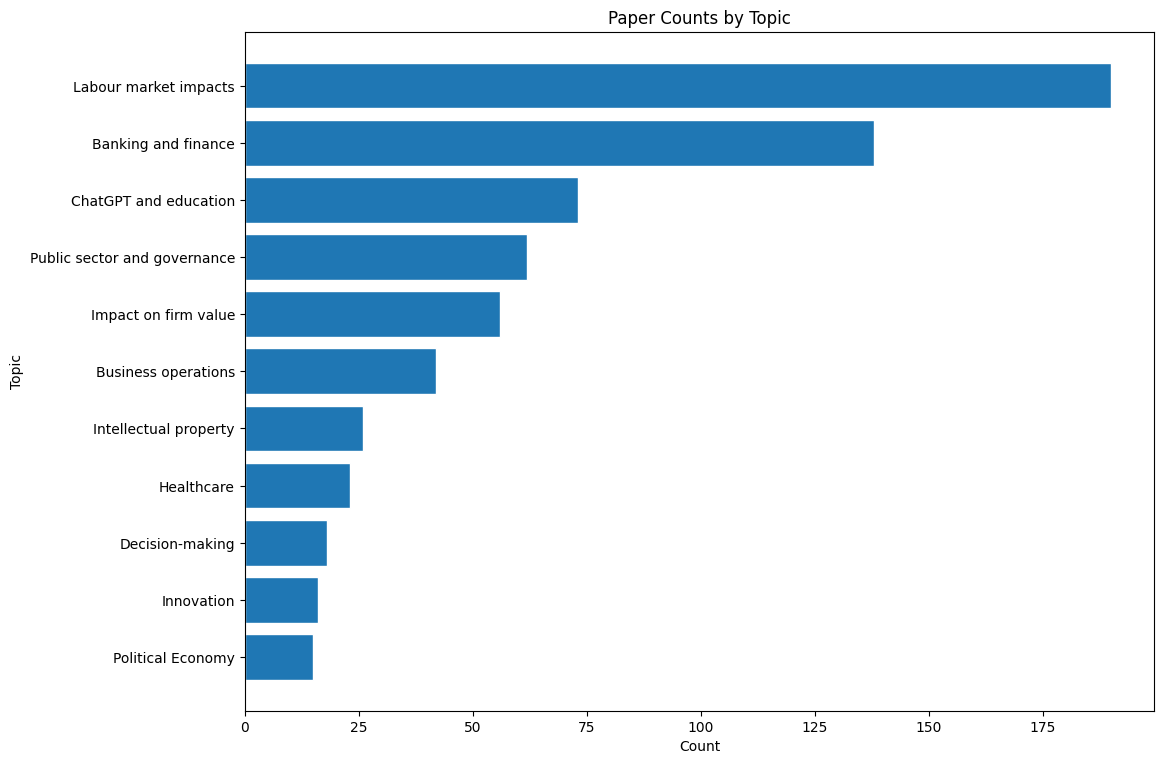

In [ ]:
# Paper counts by topic

# Filter out the '-1' topic
proper_topics = topic_df[topic_df['Topic'] != -1]

# Creating the bar chart
plt.figure(figsize=(12, 8))
plt.barh(proper_topics['Label'], proper_topics['Count'], edgecolor="white")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.title("Paper Counts by Topic")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout(pad=2)

# Saving the figure to a file
file_path = "images/counts.pdf"
plt.savefig(file_path, format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
fig = topic_model.visualize_barchart(topics = [0, 1, 2, 3, 4], custom_labels = True)
fig.show()
fig.write_image("images/bars.pdf")

In [ ]:
fig = topic_model.visualize_topics(custom_labels = True)
fig.show()
fig.write_image("images/intertopic_distances.pdf")

In [ ]:
fig = topic_model.visualize_heatmap(topics = [0, 1, 2, 3, 4], custom_labels = True, width = 800, height = 600)
fig.show()
fig.write_image("images/similarity_matrix.pdf")

In [ ]:
import plotly.graph_objects as go  # Import plotly's graph objects
from typing import List, Union

def visualize_topics_over_time(
    topic_model,
    topics_over_time: pd.DataFrame,
    top_n_topics: int = None,
    topics: List[int] = None,
    normalize_frequency: bool = False,
    custom_labels: Union[bool, str] = False,
    title: str = "<b>Topics over Time</b>",
    width: int = 1250,
    height: int = 450,
) -> go.Figure:
    """Visualize topics over time with custom line styles."""

    colors = [
        "#E69F00",
        "#56B4E9",
        "#009E73",
        "#F0E442",
        "#D55E00",
        "#0072B2",
        "#CC79A7",
    ]

    # Define custom dash patterns for each topic
    dash_styles = ['solid', 'dash', 'dot', 'dashdot', 'solid', 'dash', 'dot']

    # Select topics based on top_n and topics args
    freq_df = topic_model.get_topic_freq()
    freq_df = freq_df.loc[freq_df.Topic != -1, :]
    if topics is not None:
        selected_topics = list(topics)
    elif top_n_topics is not None:
        selected_topics = sorted(freq_df.Topic.to_list()[:top_n_topics])
    else:
        selected_topics = sorted(freq_df.Topic.to_list())

    # Prepare data
    if isinstance(custom_labels, str):
        topic_names = [[[str(topic), None]] + topic_model.topic_aspects_[custom_labels][topic] for topic in topics]
        topic_names = ["_".join([label[0] for label in labels[:4]]) for labels in topic_names]
        topic_names = [label if len(label) < 30 else label[:27] + "..." for label in topic_names]
        topic_names = {key: topic_names[index] for index, key in enumerate(topic_model.topic_labels_.keys())}
    elif topic_model.custom_labels_ is not None and custom_labels:
        topic_names = {
            key: topic_model.custom_labels_[key + topic_model._outliers] for key, _ in topic_model.topic_labels_.items()
        }
    else:
        topic_names = {
            key: value[:40] + "..." if len(value) > 40 else value for key, value in topic_model.topic_labels_.items()
        }
    topics_over_time["Name"] = topics_over_time.Topic.map(topic_names)
    data = topics_over_time.loc[topics_over_time.Topic.isin(selected_topics), :].sort_values(["Topic", "Timestamp"])

    # Add traces
    fig = go.Figure()
    for index, topic in enumerate(data.Topic.unique()):  # Loop through each unique topic
        trace_data = data.loc[data.Topic == topic, :]  # Select data for the current topic
        topic_name = trace_data.Name.values[0]  # Get the name of the current topic
        words = trace_data.Words.values  # Get the words associated with the topic
        if normalize_frequency:
            y = normalize(trace_data.Frequency.values.reshape(1, -1))[0]  # Normalize frequency if needed
        else:
            y = trace_data.Frequency  # Use raw frequency if not normalizing

        # Add trace for the current topic with a custom line style
        fig.add_trace(
            go.Scatter(
                x=trace_data.Timestamp,  # Timestamps on the x-axis
                y=y,  # Frequencies on the y-axis
                mode="lines",  # Line plot
                line=dict(
                    dash=dash_styles[index % len(dash_styles)],  # Apply different dash styles cyclically
                    width=2  # Adjust line width if needed
                ),
                marker_color=colors[index % 7],  # Cycle through predefined colors
                hoverinfo="text",  # What info to show on hover
                name=topic_name,  # Topic name
                hovertext=[f"<b>Topic {topic}</b><br>Words: {word}" for word in words],  # Hover text with topic and words
            )
        )

    # Styling of the visualization
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)
    fig.update_layout(
        yaxis_title="Normalized Frequency" if normalize_frequency else "Frequency",
        title={
            "text": f"{title}",
            "y": 0.95,
            "x": 0.40,
            "xanchor": "center",
            "yanchor": "top",
            "font": dict(size=22, color="Black"),
        },
        template="simple_white",
        width=width,
        height=height,
        hoverlabel=dict(bgcolor="white", font_size=16, font_family="Rockwell"),
        legend=dict(
            title="<b>Global Topic Representation",
        ),
    )

    return fig  # Return the figure

In [ ]:
# ## TOPICS OVER TIME
# import plotly.graph_objects as go
# import matplotlib.pyplot as plt

# # Prepare data
# timestamps = data['Publication Year'].to_list()

# # Create topics over time
# topics_over_time = topic_model.topics_over_time(documents, timestamps)

# # Visualise
# fig = visualize_topics_over_time(
#     topic_model=topic_model,
#     topics_over_time=topics_over_time,
#     topics= [0, 1, 2, 3, 4, 5],
#     custom_labels=True
# )

# # Show the figure
# fig.show()
# fig.write_image("/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/gen_AI_vs_longstanding.pdf")

In [ ]:
# ## TOPICS OVER TIME
# import plotly.graph_objects as go
# import matplotlib.pyplot as plt

# # Prepare data
# timestamps = data['Publication Year'].to_list()

# # Create topics over time
# topics_over_time = topic_model.topics_over_time(documents, timestamps)

# # Visualise
# fig = visualize_topics_over_time(
#     topic_model=topic_model,
#     topics_over_time=topics_over_time,
#     topics= [1, 5, 10],
#     custom_labels=True
# )

# # Show the figure
# fig.show()
# fig.write_image("/content/drive/MyDrive/AI Landscape Collaboration/Colab Notebooks/images/supply_chains.pdf")

In [ ]:
docs_df = pd.DataFrame({'abstract': documents})
docs_cits = docs_df.merge(papers_topics[['abstract', 'Cited by']], on = 'abstract', how = 'left')[['abstract', 'Cited by']]
docs_cits = docs_cits.dropna(subset = 'Cited by')
docs_cits = docs_cits.drop_duplicates(subset = ['abstract'])
docs_cits

,abstract,Cited by
0,Do stronger intellectual property rights incen...,0.0
1,Drawing insights from the field of innovation ...,32.0
2,How will the emergence of ChatGPT and other fo...,19.0
3,David Ricardo initially believed machinery wou...,8.0
4,Timely and accurate measurement of AI use by f...,23.0
...,...,...
1026,Can artificial intelligence (AI) assist human ...,237.0
1027,This paper looks at transparency and fintech t...,1.0
1028,The knowledge-based and data-driven economy re...,42.0
1029,Credit risk is probably the most regulated app...,1.0


In [ ]:
# Get embeddings

from sentence_transformers import SentenceTransformer
import numpy as np

documents = docs_cits['abstract'].to_list()
embedding_model = SentenceTransformer("all-roberta-large-v1")
embeddings = embedding_model.encode(documents, show_progress_bar=True)
embeddings = embeddings.astype(np.float64)

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

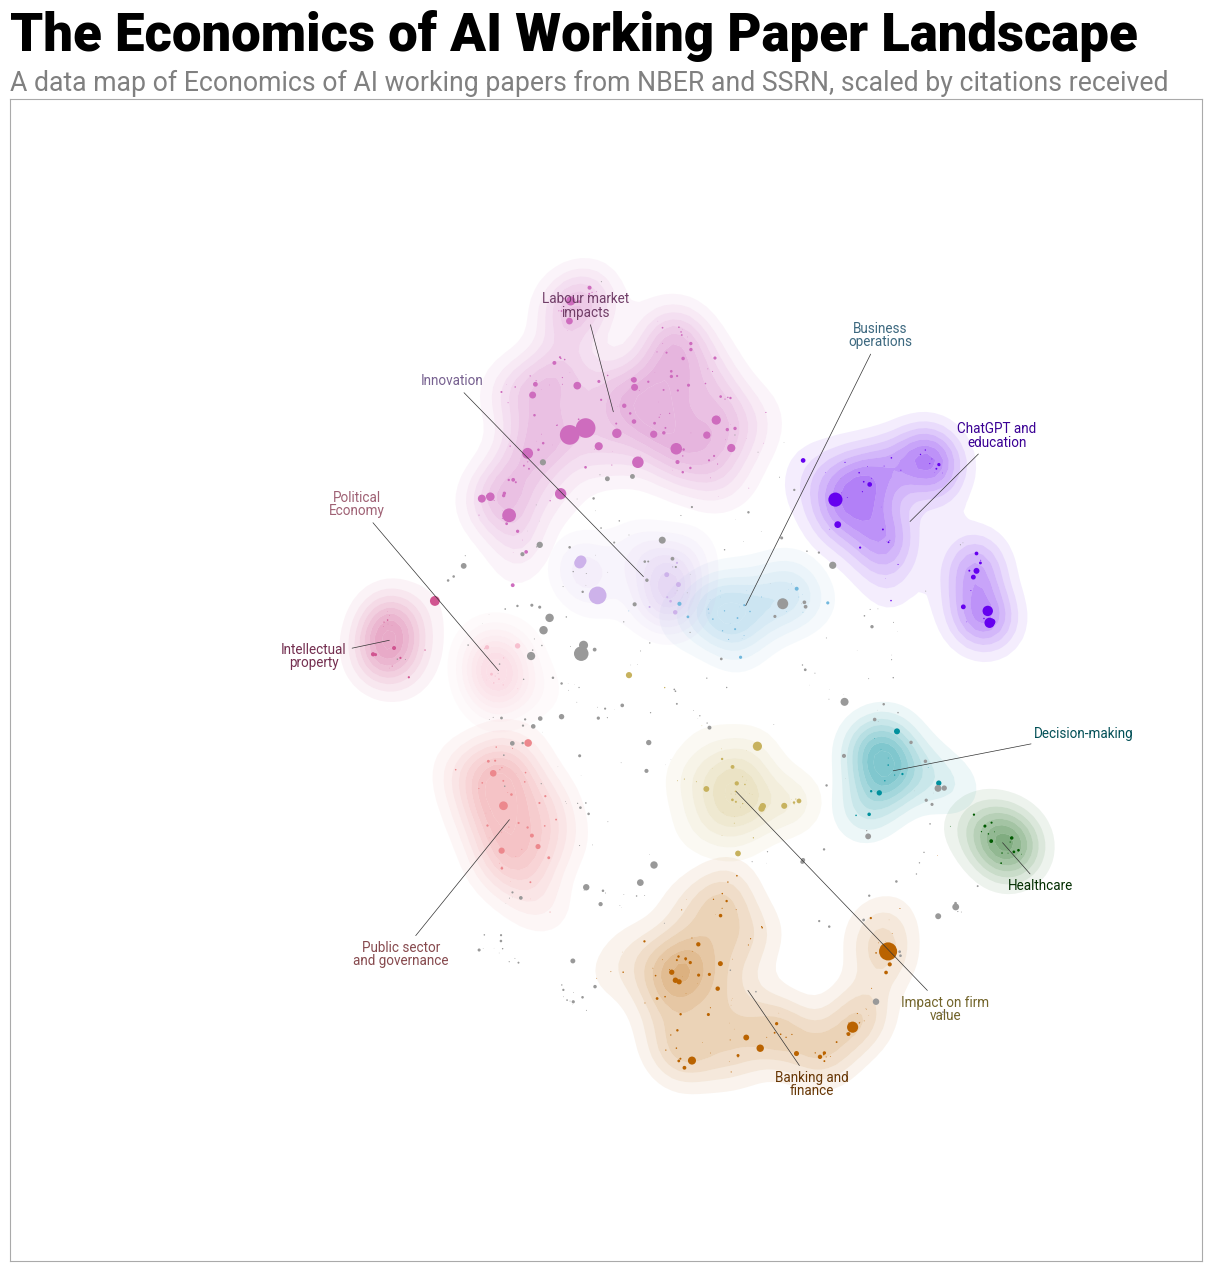

In [ ]:
import plotly.io as pio
import datamapplot
import matplotlib

citations = docs_cits['Cited by'].to_list()
scaled_citations = [2*(c / max(citations)) * 100 for c in citations]
fig = topic_model.visualize_document_datamap(documents, custom_labels = True, embeddings=embeddings, point_size=scaled_citations, title="The Economics of AI Working Paper Landscape", sub_title="A data map of Economics of AI working papers from NBER and SSRN, scaled by citations received")
fig.show()
fig.savefig("images/landscape_wps.pdf", dpi=600, bbox_inches='tight')

In [ ]:
# citations summary stats

avg_citations = papers_topics_full['Cited by'].mean()

papers_topics_full['normalized_citations'] = papers_topics_full['Cited by']/avg_citations
papers_topics_full['normalized_citations'] = papers_topics_full['normalized_citations'].fillna(0)

topics_citations_sum = papers_topics_full[['normalized_citations', 'Topic']].groupby('Topic').sum().reset_index().rename(columns = {'normalized_citations':'sum_citations'})
topics_citations_average = papers_topics_full[['normalized_citations', 'Topic']].groupby('Topic').mean().reset_index().rename(columns = {'normalized_citations':'mean_citations'})
topics_citations_median = papers_topics_full[['normalized_citations', 'Topic']].groupby('Topic').median().reset_index().rename(columns = {'normalized_citations':'med_citations'})
topics_citations_max = papers_topics_full[['normalized_citations', 'Topic']].groupby('Topic').max().reset_index().rename(columns = {'normalized_citations':'max_citations'})

topics_citations = pd.merge(topics_citations_sum, topics_citations_average, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_median, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_max, on = 'Topic', how = 'inner')

topics_citations.sort_values('mean_citations', ascending=False)

,Topic,sum_citations,mean_citations,med_citations,max_citations
10,9,73.352393,4.584525,0.499978,35.954006
1,0,334.785568,1.762029,0.188881,44.309201
3,2,85.285212,1.168291,0.088885,22.932345
2,1,125.327931,0.908173,0.111106,37.487273
5,4,46.820204,0.836075,0.044443,9.666250
9,8,14.466043,0.803669,0.188881,4.088713
0,-1,265.188568,0.712872,0.111106,24.310063
7,6,18.088109,0.695697,0.022221,11.155075
4,3,40.953790,0.660545,0.099996,8.777399
11,10,7.932991,0.528866,0.155549,3.333190


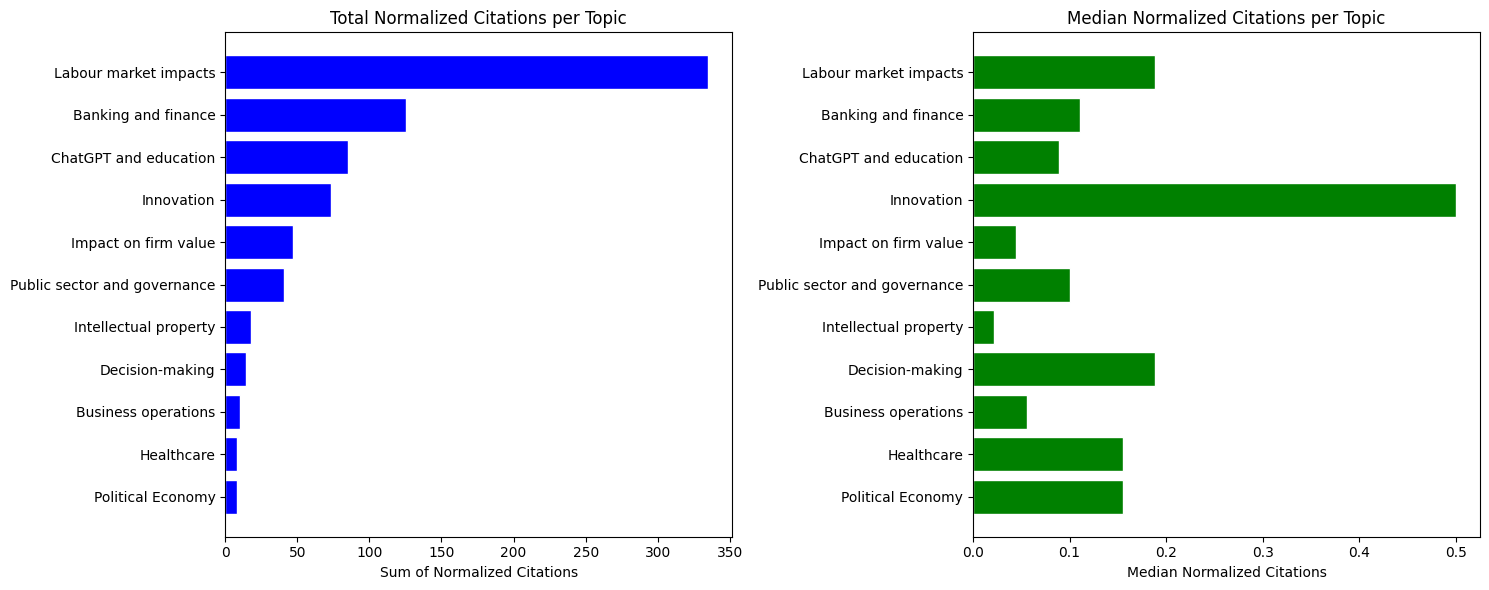

In [ ]:
## Citations bar charts

topics_citations_label = topics_citations.copy()
topics_citations_label['Label'] = topics_citations['Topic'].apply(lambda x: custom_topic_labels[x])
topics_citations_label = topics_citations_label[(topics_citations_label['Topic'] <= 10) & (topics_citations_label['Topic'] != -1)]
topics_citations_label = topics_citations_label.sort_values(by='sum_citations', ascending=False)

# Creating the plot with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Total Citations bar chart
axes[0].barh(topics_citations_label['Label'], topics_citations_label['sum_citations'], color='blue', edgecolor="white")
axes[0].set_title("Total Normalized Citations per Topic")
axes[0].set_xlabel("Sum of Normalized Citations")
axes[0].invert_yaxis()  # Invert y-axis for better readability

# Mean Citations bar chart
axes[1].barh(topics_citations_label['Label'], topics_citations_label['med_citations'], color='green', edgecolor="white")
axes[1].set_title("Median Normalized Citations per Topic")
axes[1].set_xlabel("Median Normalized Citations")
axes[1].invert_yaxis()  # Ensure both y-axes match

# Adjust layout and show
plt.tight_layout()
plt.show()

file_path_cits = "images/citations_by_topic_wps.pdf"
fig.savefig(file_path_cits, format="pdf", bbox_inches="tight")